In [12]:
import pandas as pd

df = pd.read_csv('df_standard.csv')

# Initialize the lockscreen column with zeros
df['lockscreen'] = 0
# Group by 'trajectory_Id' and iterate over groups
for traj_id, group in df.groupby('trajectory_Id'):
    # Initialize lock screen state for each trajectory
    lock_screen = False
    
    # Iterate over rows in the group
    for index, row in group.iterrows():
        # Check if mapInteractions column has 'mapLog:isScreenLocked+True'
        if row['mapInteractions'] == 'mapLog:isScreenLocked+True':
            # Set lock_screen to True
            lock_screen = True
        # Check if mapInteractions column has 'mapLog:isScreenLocked+False'
        elif row['mapInteractions'] == 'mapLog:isScreenLocked+False':
            # Set lock_screen to False
            lock_screen = False
        # Assign 1 to lockscreen column if lock_screen is True
        if lock_screen:
            df.at[index, 'lockscreen'] = 1

df.to_csv('df_sa.csv')


In [21]:
# distinguish light and heavy traffic density 
import pandas as pd

# Load the dataset
# Assuming the dataset is in a CSV file named 'data.csv'
df = pd.read_csv('df_sa.csv')

# Convert 'DateTime' column to datetime objects
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Initialize new columns for planning time and navigation time
df['active_time'] = 0
df['inactive_time'] = 0
# Group by 'trajectory_Id' and iterate over groups
for traj_id, group in df.groupby('trajectory_Id'):
    # Initialize variables to track previous time and index for planning and navigation phases
    prev_active_time = None
    prev_inactive_time = None
    prev_active_index = None
    prev_inactive_index = None
    
    # Iterate over rows in the group
    for index, row in group.iterrows():
        if row['lockscreen'] == 0:
            if prev_active_time is None:
                prev_active_time = row['DateTime']
                prev_inactive_index = index
            else:
                current_time = row['DateTime']
                active_time = (current_time - prev_active_time).total_seconds()
                df.at[index, 'active_time'] = active_time
                prev_active_time = current_time
                prev_active_index = index
            # Reset navigation variables when encountering planning phase
            prev_inactive_time = None
            
        elif row['lockscreen'] == 1:
            if prev_inactive_time is None:
                prev_inactive_time = row['DateTime']
                prev_inactive_index = index
            else:
                current_time = row['DateTime']
                prev_inactive_time = (current_time - prev_inactive_time).total_seconds()
                df.at[index, 'inactive_time'] = prev_inactive_time
                prev_inactive_time = current_time
                prev_inactive_index = index
            # Reset planning variables when encountering navigation phase
            prev_active_time = None

# df_sa_light = df[(df['scenario'] == 1) | (df['scenario'] == 2)]
# df_sa_heavy = df[(df['scenario'] == 3) | (df['scenario'] == 4)]
df.to_csv('df_sa_time.csv')


In [27]:
import pandas as pd

# Sample data loading 
df = pd.read_csv('df_sa_time.csv')

# Create a new DataFrame to store event information
events = []
current_event = None

# Iterate through the rows
for index, row in df.iterrows():
    if row['lockscreen'] == 1:
        if current_event is None:
            current_event = {
                'event_number': len(events) + 1,
                'participant': row['participant'],
                'trajectory_Id': row['trajectory_Id'],
                'traffic_density' : row['scenario'],
                'map_type' : row['scenario'],
                'total_inactive_time': 0
            }
        current_event['total_inactive_time'] += row['inactive_time']
    else:
        if current_event is not None:
            events.append(current_event)
            current_event = None

# If the last row is part of an event, append it
if current_event is not None:
    events.append(current_event)

# Convert the list of events to a DataFrame
events_df = pd.DataFrame(events)
events_df['state'] = 1
events_df['traffic_density'] = events_df['traffic_density'].replace({1: 0, 2: 0, 3: 1, 4: 1})
events_df['map_type'] = events_df['map_type'].replace({1: 0, 2: 1, 3: 0, 4: 1})

# Display the new DataFrame
events_df.to_csv('df_sa_result.csv')


In [6]:
# feature of time_from_start:
import pandas as pd

df = pd.read_csv('df_sa_time.csv')

# Convert DateTime to datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Filter rows where lockscreen is False
unlocked_data = df[df['mapInteractions'] == 'mapLog:isScreenLocked+True']

# Compute the time difference for each trajectory_Id
time_durations = []

for trajectory_id, group in df.groupby('trajectory_Id'):
    first_row_time = group.iloc[0]['DateTime']
    unlocked_rows = unlocked_data[unlocked_data['trajectory_Id'] == trajectory_id]
    
    for _, unlocked_row in unlocked_rows.iterrows():
        unlocked_row_time = unlocked_row['DateTime']
        time_diff = (unlocked_row_time - first_row_time).total_seconds()
        time_durations.append({
            'trajectory_Id': trajectory_id,
            'unlocked_row_index': unlocked_row.name,
            'time_diff': time_diff
        })

# Create a DataFrame for the results
time_durations_df = pd.DataFrame(time_durations)

# Display the results
print(time_durations_df)

      trajectory_Id  unlocked_row_index  time_diff
0                 1                  25     10.377
1                 1                  58     25.716
2                 2                 169     10.329
3                 2                 226     36.706
4                 2                 352     99.216
...             ...                 ...        ...
3118            863              159607     10.230
3119            863              159630     21.239
3120            863              159655     32.626
3121            863              159679     43.724
3122            863              159705     55.886

[3123 rows x 3 columns]


In [28]:
# feature of previous active time.

import pandas as pd

df = pd.read_csv('df_sa_time.csv')

# Convert DateTime to datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Initialize event number and previous active time
time_previous = []

event_number = 0

event_start = False

# Group by 'trajectory_Id' and iterate over each group
for trajectory_id, group in df.groupby('trajectory_Id'):
    # Initialize event number and previous active time for each group
    # event_number = 0
    previous_active_time = 0
    # event_start = False

    for i, row in group.iterrows():
        if row['lockscreen'] == 0:
            if not event_start:
                event_number += 1
                event_start = True
                previous_active_time = 0
            previous_active_time += row['active_time']
        else:
            time_previous.append({
                'trajectory_Id': trajectory_id,
                'event': event_number,
                'time_previous': previous_active_time
            })
            event_start = False

time_previous_df = pd.DataFrame(time_previous)
time_previous_df = time_previous_df.drop_duplicates(subset=['event'])

# Reset index
time_previous_df = time_previous_df.reset_index(drop=True)
# Display the results
print(time_previous_df)


      trajectory_Id  event  time_previous
0                 1      1          9.889
1                 1      2          9.850
2                 2      3         10.155
3                 2      4         10.262
4                 2      5          9.969
...             ...    ...            ...
3118            863   3119         10.163
3119            863   3120          9.828
3120            863   3121         10.052
3121            863   3122         10.041
3122            863   3123          9.863

[3123 rows x 3 columns]


In [30]:
# combine results
import pandas as pd 
df = pd.read_csv('df_sa_result.csv')

df = pd.merge(df, time_previous_df['time_previous'], left_index=True, right_index=True)
df = pd.merge(df, time_durations_df['time_diff'], left_index=True, right_index=True)

print(df)

df.to_csv('try_sa.csv')


      Unnamed: 0  event_number  participant  trajectory_Id  traffic_density  \
0              0             1            8              1                0   
1              1             2            8              1                0   
2              2             3            8              2                0   
3              3             4            8              2                0   
4              4             5            8              2                0   
...          ...           ...          ...            ...              ...   
3118        3118          3119           63            863                1   
3119        3119          3120           63            863                1   
3120        3120          3121           63            863                1   
3121        3121          3122           63            863                1   
3122        3122          3123           63            863                1   

      map_type  total_inactive_time  state  time_pr

In [31]:
# create road network 
from shapely.geometry import Point, LineString

# Define road network using nodes and edges (graph representation)
nodes = {
    'v11': Point(-1250.9, -651.57),    # E1
    'v12': Point(-1250.9, -1210.7),

    'v21': Point(-1150.9, -550.99),  # E1
    'v22': Point(-1150.9, -1009.71),
    'v23': Point(-1150.9, -1151.07),
    'v24': Point(-1150.9, -1310.3),

    'v31': Point(-1050.9, -449.6),
    'v32': Point(-1050.9, -1131.9),
    'v33': Point(-1050.9, -1332.2),
    'v34': Point(-1050.9, -1417.2),

    'v41': Point(-950.9, -552.3),
    'v42': Point(-950.9, -1013.1),
    'v43': Point(-950.9, -1131.9),
    'v44': Point(-950.9, -1332.2),

    'v51': Point(-850.9, -552.3),
    'v52': Point(-850.9, -712.3),
    'v53': Point(-850.9, -845.5),
    'v54': Point(-850.9, -1017.5),
    'v55': Point(-850.9, -1131.9),
    'v56': Point(-850.9, -1332.2),

    'v61': Point(-750.9, -452.3),
    'v62': Point(-750.9, -531.7),
    'v63': Point(-750.9, -732.4),
    'v64': Point(-750.9, -829.3),
    'v65': Point(-750.9, -1034.4),
    'v66': Point(-750.9, -1131.8),
    'v67': Point(-750.9, -1331.7),
    'v68': Point(-750.9, -1413),

    'v71': Point(-650.9, -1146.7),
    'v72': Point(-650.9, -1315.1),

    'v81': Point(-600.9, -531.7), #symmetric 
    'v82': Point(-600.9, -592.6),
    'v83': Point(-600.9, -672.7),
    'v84': Point(-600.9, -731.8),
    'v85': Point(-600.9, -829.8),
    'v86': Point(-600.9, -1034.1),

    'v-71': Point(-550, -1146.7),
    'v-72': Point(-550, -1315.1),

    'v-61': Point(-450, -452.3),
    'v-62': Point(-450, -531.7),
    'v-63': Point(-450, -732.4),
    'v-64': Point(-450, -829.3),
    'v-65': Point(-450, -1034.4),
    'v-66': Point(-450, -1131.8),
    'v-67': Point(-450, -1331.7),
    'v-68': Point(-450, -1413),

    'v-52': Point(-350, -712.3), 
    'v-51': Point(-350, -552.3),
    'v-53': Point(-350, -845.5),
    'v-54': Point(-350, -1017.5),
    'v-55': Point(-307, -1131.9),
    'v-56': Point(-307, -1332.2),

    'v-41': Point(-250, -552.3),
    'v-42': Point(-250, -1013.1),
    'v-43': Point(-250, -1131.9),
    'v-44': Point(-250, -1332.2),
    
    'v-31': Point(-150, -449.6),
    'v-32': Point(-150, -1131.9),
    'v-33': Point(-150, -1332.2),
    'v-34': Point(-150, -1417.2),

    'v-21': Point(-50, -550.99),  
    'v-22': Point(-50, -1009.71),
    'v-23': Point(-50, -1151.07),
    'v-24': Point(-50, -1310.3),

    'v-11': Point(50, -651.57),   
    'v-12': Point(50, -1210.7), 

    # horizontal   
    'h11': Point(-1030, -432),    
    'h12': Point(-771, -432),
    'h13': Point(-430.8, -432),    
    'h14': Point(-339.5, -432),
    'h15': Point(-260.8, -432),    
    'h16': Point(-167.2, -432),

    'h21': Point(-1132.7, -532),    
    'h22': Point(-966.9, -532),
    'h23': Point(-833.6, -532),    
    'h24': Point(-366.5, -532),
    'h25': Point(-233.3, -532),    
    'h26': Point(-66.7, -532),

    'h31': Point(-1232.3, -632),    
    'h32': Point(-1149.9, -632),
    'h33': Point(-949.7, -632),    
    'h34': Point(-639.7, -632),
    'h35': Point(-561.4, -632),    
    'h36': Point(-249.7, -632),
    'h37': Point(-50, -632),    
    'h38': Point(33, -632),

    'h41': Point(-831.9, -732),    
    'h42': Point(-369.6, -732),
    'h43': Point(-250, -732),    
    'h44': Point(-50, -732),

    'h51': Point(-1149.8, -782),    
    'h52': Point(-950, -782),

    'h61': Point(-834.18, -832),    
    'h62': Point(-362.9, -832),
    'h63': Point(-249.2, -832),    
    'h64': Point(-50, -832),

    'h71': Point(-1250, -932),    
    'h72': Point(-1150, -932),
    'h73': Point(-950, -932),    
    'h74': Point(-250, -932),
    'h75': Point(-50, -932),    
    'h76': Point(50, -932),

    'h81': Point(-1150, -1032),    
    'h82': Point(-950, -1032),
    'h83': Point(-850, -1032),    
    'h84': Point(-350, -1032),
    'h85': Point(-250, -1032),    
    'h86': Point(-50, -1032),

    'h91': Point(-1138.1, -1132),    
    'h92': Point(-666.8, -1132),
    'h93': Point(-536, -1132),    
    'h94': Point(-63.3, -1132),

    'h101': Point(-1234, -1232),    
    'h102': Point(-950, -1232),
    'h103': Point(-850, -1232),    
    'h104': Point(31.8, -1232),

    'h111': Point(-1134.2, -1332),    
    'h112': Point(-665.6, -1332),
    'h113': Point(-534.1, -1332),    
    'h114': Point(-66.8, -1332),

    'h121': Point(-1033.6, -1432),    
    'h122': Point(-766.5, -1432),
    'h123': Point(-434.6, -1432),    
    'h124': Point(-165.4, -1432),

    # circle
    'c11': Point(-628.4, -605.8),    
    'c12': Point(-570.4, -605.8),
    'c13': Point(-570.4, -658.9),    
    'c14': Point(-628.4, -658.9),

    'c21': Point(-329.7, -406.4),    
    'c22': Point(-269.1, -406.4),
    'c23': Point(-269.1, -457.7),    
    'c24': Point(-329.7, -457.7),
    'cc1': Point(-299.9, -392.1),
    'cc2': Point(-299.9, -471.3),


}

# Define road segments as LineString objects between nodes
road_segments = [
    # vertical
    LineString([nodes['v11'], nodes['v12']]),  

    LineString([nodes['v21'], nodes['v22']]),
    LineString([nodes['v23'], nodes['v24']]),  

    LineString([nodes['v31'], nodes['v32']]), 
    LineString([nodes['v33'], nodes['v34']]), 

    LineString([nodes['v41'], nodes['v42']]), 
    LineString([nodes['v43'], nodes['v44']]), 

    LineString([nodes['v51'], nodes['v52']]), 
    LineString([nodes['v53'], nodes['v54']]), 
    LineString([nodes['v55'], nodes['v56']]), 

    LineString([nodes['v61'], nodes['v62']]), 
    LineString([nodes['v63'], nodes['v64']]), 
    LineString([nodes['v65'], nodes['v66']]), 
    LineString([nodes['v67'], nodes['v68']]), 

    LineString([nodes['v71'], nodes['v72']]),  

    
    LineString([nodes['v81'], nodes['v82']]), 
    LineString([nodes['v83'], nodes['v84']]), 
    LineString([nodes['v85'], nodes['v86']]), 

    LineString([nodes['v-11'], nodes['v-12']]),  
    LineString([nodes['v-21'], nodes['v-22']]),
    LineString([nodes['v-23'], nodes['v-24']]),  
    LineString([nodes['v-31'], nodes['v-32']]), 
    LineString([nodes['v-33'], nodes['v-34']]), 
    LineString([nodes['v-41'], nodes['v-42']]), 
    LineString([nodes['v-43'], nodes['v-44']]), 
    LineString([nodes['v-51'], nodes['v-52']]), 
    LineString([nodes['v-53'], nodes['v-54']]), 
    LineString([nodes['v-55'], nodes['v-56']]), 
    LineString([nodes['v-61'], nodes['v-62']]), 
    LineString([nodes['v-63'], nodes['v-64']]), 
    LineString([nodes['v-65'], nodes['v-66']]), 
    LineString([nodes['v-67'], nodes['v-68']]), 
    LineString([nodes['v-71'], nodes['v-72']]),  

    # horizontal 
    LineString([nodes['h11'], nodes['h12']]),  
    LineString([nodes['h13'], nodes['h14']]),  
    LineString([nodes['h15'], nodes['h16']]),  

    LineString([nodes['h21'], nodes['h22']]),  
    LineString([nodes['h23'], nodes['h24']]),  
    LineString([nodes['h25'], nodes['h26']]),  

    LineString([nodes['h31'], nodes['h32']]),  
    LineString([nodes['h33'], nodes['h34']]),  
    LineString([nodes['h35'], nodes['h36']]), 
    LineString([nodes['h37'], nodes['h38']]),  

    LineString([nodes['h41'], nodes['h42']]),  
    LineString([nodes['h43'], nodes['h44']]),  

    LineString([nodes['h51'], nodes['h52']]),  

    LineString([nodes['h61'], nodes['h62']]),  
    LineString([nodes['h63'], nodes['h64']]),  

    LineString([nodes['h71'], nodes['h72']]),  
    LineString([nodes['h73'], nodes['h74']]),  
    LineString([nodes['h75'], nodes['h76']]), 

    LineString([nodes['h81'], nodes['h82']]),  
    LineString([nodes['h83'], nodes['h84']]),  
    LineString([nodes['h85'], nodes['h86']]), 

    LineString([nodes['h91'], nodes['h92']]),  
    LineString([nodes['h93'], nodes['h94']]),  

    LineString([nodes['h101'], nodes['h102']]),  
    LineString([nodes['h103'], nodes['h104']]),  

    LineString([nodes['h111'], nodes['h112']]),  
    LineString([nodes['h113'], nodes['h114']]),  

    LineString([nodes['h121'], nodes['h122']]),  
    LineString([nodes['h123'], nodes['h124']]),  

    # curve
    LineString([nodes['v11'], nodes['h31']]),  
    LineString([nodes['v12'], nodes['h101']]),

    LineString([nodes['v21'], nodes['h21']]),  
    LineString([nodes['v22'], nodes['h81']]),
    LineString([nodes['v23'], nodes['h91']]),
    LineString([nodes['v24'], nodes['h111']]),

    LineString([nodes['v31'], nodes['h11']]), 
    LineString([nodes['v34'], nodes['h121']]), 

    LineString([nodes['v41'], nodes['h22']]),  
    LineString([nodes['v42'], nodes['h82']]),

    LineString([nodes['v51'], nodes['h23']]),
    LineString([nodes['v52'], nodes['h41']]),
    LineString([nodes['v53'], nodes['h61']]),
    LineString([nodes['v54'], nodes['h83']]),

    LineString([nodes['v61'], nodes['h12']]),
    LineString([nodes['v68'], nodes['h122']]),

    LineString([nodes['v71'], nodes['h92']]),
    LineString([nodes['v72'], nodes['h112']]),

    LineString([nodes['v-71'], nodes['h93']]),
    LineString([nodes['v-72'], nodes['h113']]),

    LineString([nodes['v-61'], nodes['h13']]),
    LineString([nodes['v-68'], nodes['h123']]),

    LineString([nodes['v-51'], nodes['h24']]),
    LineString([nodes['v-52'], nodes['h42']]),
    LineString([nodes['v-53'], nodes['h62']]),
    LineString([nodes['v-54'], nodes['h84']]),

    LineString([nodes['v-41'], nodes['h25']]),  
    LineString([nodes['v-42'], nodes['h85']]),

    LineString([nodes['v-31'], nodes['h16']]), 
    LineString([nodes['v-34'], nodes['h124']]), 

    LineString([nodes['v-21'], nodes['h26']]),  
    LineString([nodes['v-22'], nodes['h86']]),
    LineString([nodes['v-23'], nodes['h94']]),
    LineString([nodes['v-24'], nodes['h114']]),

    LineString([nodes['v-11'], nodes['h38']]),  
    LineString([nodes['v-12'], nodes['h104']]),

    #circle 
    LineString([nodes['h34'], nodes['c11']]),  
    LineString([nodes['c11'], nodes['v82']]),  
    LineString([nodes['v82'], nodes['c12']]),  
    LineString([nodes['c12'], nodes['h35']]),  
    LineString([nodes['h35'], nodes['c13']]),  
    LineString([nodes['c13'], nodes['v83']]),  
    LineString([nodes['v83'], nodes['c14']]),  
    LineString([nodes['c14'], nodes['h34']]), 

    LineString([nodes['h14'], nodes['c21']]),  
    LineString([nodes['c21'], nodes['cc1']]),  
    LineString([nodes['cc1'], nodes['c22']]),  
    LineString([nodes['c22'], nodes['h15']]),  
    LineString([nodes['h15'], nodes['c23']]),  
    LineString([nodes['c23'], nodes['cc2']]),  
    LineString([nodes['cc2'], nodes['c24']]),  
    LineString([nodes['c24'], nodes['h14']]),   

]

In [34]:
# whether cross road in the previous phase.
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point

df = pd.read_csv('df_sa_time.csv')  

road_gdf = gpd.GeoDataFrame(geometry=road_segments)

def check_intersection(phase_points, road_gdf):
    phase_line = LineString(phase_points)
    for road_segment in road_gdf.geometry:
        if phase_line.intersects(road_segment):
            return 1
    return 0

phases = []
current_phase = []
event_number = 1
current_trajectory_Id = None

for i, row in df.iterrows():
    if row['lockscreen'] == 0:
        current_phase.append((row['posX'], row['posZ']))
        if current_trajectory_Id is None:
            current_trajectory_Id = row['trajectory_Id']
    else:
        if current_phase:
            phases.append((event_number, current_phase, current_trajectory_Id))
            current_phase = []
            current_trajectory_Id = None
            event_number += 1

if current_phase:
    phases.append((event_number, current_phase,current_trajectory_Id))

event_crossroad = []

for event_number, phase_points,trajectory_Id in phases:
    crossroad = check_intersection(phase_points, road_gdf)
    event_crossroad.append({'event': event_number, 'crossroad': crossroad, 'trajectory_Id': trajectory_Id})

result_df = pd.DataFrame(event_crossroad)

print(result_df)



      event  crossroad  trajectory_Id
0         1          0              1
1         2          1              1
2         3          1              1
3         4          0              2
4         5          0              2
...     ...        ...            ...
3119   3120          0            863
3120   3121          0            863
3121   3122          0            863
3122   3123          0            863
3123   3124          0            863

[3124 rows x 3 columns]


In [35]:
# combine results
import pandas as pd 
df = pd.read_csv('try_sa.csv')

df = pd.merge(df, result_df['crossroad'], left_index=True, right_index=True)

print(df)

df.to_csv('try_sa1.csv')

      Unnamed: 0.1  Unnamed: 0  event_number  participant  trajectory_Id  \
0                0           0             1            8              1   
1                1           1             2            8              1   
2                2           2             3            8              2   
3                3           3             4            8              2   
4                4           4             5            8              2   
...            ...         ...           ...          ...            ...   
3118          3118        3118          3119           63            863   
3119          3119        3119          3120           63            863   
3120          3120        3120          3121           63            863   
3121          3121        3121          3122           63            863   
3122          3122        3122          3123           63            863   

      traffic_density  map_type  total_inactive_time  state  time_previous  \
0        

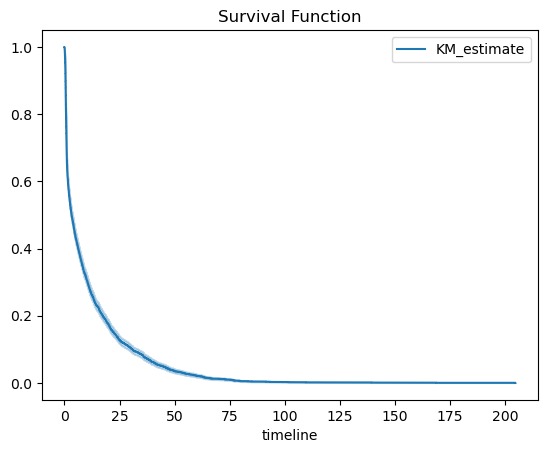

In [36]:
# plot 4 basic function for the data
import pandas as pd 
from lifelines import KaplanMeierFitter

df = pd.read_csv('try_sa1.csv')

kmf = KaplanMeierFitter()
kmf.fit(durations=df['total_inactive_time'], event_observed=df['state'])

import matplotlib.pyplot as plt

kmf.plot_survival_function()
plt.title('Survival Function')
plt.show()
